<a href="https://colab.research.google.com/github/lucaCosca/JetNet_ML-Final-Project/blob/main/Model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modules Import, DataLoader class and ModelEval class

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from jetnet.datasets import JetNet
from jetnet.utils import to_image
from sklearn.preprocessing import OneHotEncoder

class DataLoader:
  def __init__(self):
    pass

  def get_data(num_images=70000, LAST=False, SAVE = False, SKIPTRAIN = 0):
    ''' DOWNLOAD DATA '''
    #set args to load the data
    data_args = {
        "jet_type": ["g", "q", "t", "w", "z"],
        # ‘g’ (gluon), ‘q’ (light quarks), ‘t’ (top quarks), ‘w’ (W bosons), or ‘z’ (Z bosons)
        "data_dir": "datasets/jetnet",
        # only selecting the kinematic features
        "particle_features": ["etarel", "phirel", "ptrel"],
        "num_particles": 30,
        "jet_features": ["type"],
        "download": True,
        "split": "all",
    }

    # download as numpy arrays
    particle_data, jet_data = JetNet.getData(**data_args)

    ''' TRANSFORM TO IMAGES '''
    #num_images = 70000 #total number of images
    im_size = 50 #pixel size of the length of the image
    maxR=0.4 #maximum radius of the jet
    if LAST == True:
      X_train = np.array( [to_image(particle_data[88000 - num_images + i], im_size, maxR=maxR) for i in range(num_images)] )
      Y_train = jet_data[-num_images:]
    elif SKIPTRAIN > 0:
      X_train = np.array( [to_image(particle_data[i], im_size, maxR=maxR) for i in range(SKIPTRAIN, num_images)] )
      Y_train = jet_data[SKIPTRAIN:num_images]
    else:
      X_train = np.array( [to_image(particle_data[i], im_size, maxR=maxR) for i in range(num_images)] )
      Y_train = jet_data[:num_images]

    if SAVE and LAST:
      np.savez("X_test_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", X_train)
      np.savez("Y_test_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", Y_train)
    elif SAVE:
      np.savez("X_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", X_train)
      np.savez("Y_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", Y_train)

    return X_train, Y_train

  def get_data_onehot(train=42000, valid=14000, test=14000, SAVE = False, SKIPTRAIN = False):
    if SKIPTRAIN == True:
      X_Data, Y_Data = DataLoader.get_data(train+valid, SAVE = SAVE, SKIPTRAIN=train)
      # data split
      X_train = X_Data[:1]
      X_val = X_Data[1:]
      Y_train = Y_Data[:1]
      Y_val = Y_Data[1:]
    else:
      X_Data, Y_Data = DataLoader.get_data(train+valid, SAVE = SAVE)
      # data split
      X_train, X_val = X_Data[:train], X_Data[train:]
      Y_train, Y_val = Y_Data[:train], Y_Data[train:]

    X_test, Y_test = DataLoader.get_data(test, LAST=True, SAVE = SAVE)

    # one hot encoding the lables
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_train_onehot = one_hot_encoder.fit_transform(Y_train.reshape((-1,1)))
    Y_valid_onehot = one_hot_encoder.fit_transform(Y_val.reshape((-1,1)))
    Y_test_onehot = one_hot_encoder.fit_transform(Y_test.reshape((-1,1)))

    return X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot


In [5]:
X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot = DataLoader.get_data_onehot(train=1, valid=30000, test=30000, SAVE = False, SKIPTRAIN=True)


In [45]:
class ModelEval:
  def __init__(self, model, X_valid_set, Y_valid_set, model_str="model", cmap='inferno'):
    self.X_valid = X_valid_set
    self.Y_valid = Y_valid_set
    self.cmap = cmap
    self.model_str = model_str
    self.model = model
    self.dict_labels = {'g': "gluon", "q": "light quarks", "t": "top quarks", "w": "W bosons", "z": "Z bosons"}

    self.Y_valid_pred = self.model.predict(self.X_valid)
    self.Y_valid_pred_classes = np.argmax(self.Y_valid_pred, axis=1)
    self.Y_valid_classes = np.argmax(self.Y_valid, axis=1)

  def return_predictions(self):
    return self.Y_valid_pred, self.Y_valid_pred_classes, self.Y_valid_classes

  def confusion_matrix(self):
    from sklearn.metrics import confusion_matrix
    conf_m = confusion_matrix(self.Y_valid_classes, self.Y_valid_pred_classes)
    print("Confusion matrix of " + self.model_str)
    print(conf_m)
    plt.matshow(conf_m, cmap=self.cmap)
    plt.title("Confusion matrix of " + self.model_str)
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.xticks(range(5), ["gluon", "light quarks", "top quark", "W boson", "Z boson"])
    plt.yticks(range(5), ["gluon", "light quarks", "top quark", "W boson", "Z boson"])

  def PR_study_multiclass(self):
    from sklearn.metrics import average_precision_score, precision_recall_curve
    # Precision-Recall analysis for each class
    average_precision = dict()
    PR_curve = []
    for i in range(5):
        PR_curve.append( precision_recall_curve(self.Y_valid[:,i], self.Y_valid_pred[:, i]) )
        average_precision[i] = average_precision_score(self.Y_valid[:,i], self.Y_valid_pred[:, i])
        plt.plot(PR_curve[i][1], PR_curve[i][0], label='Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Model: " + self.model_str)
    plt.legend(["gluon", "light quarks", "top quark", "W boson", "Z boson"])
    plt.show()

## Model Definifition (DenseNet)

In [2]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_blocks, grow_rate, **kwargs):
        super().__init__(**kwargs)
        self.num_blocks = num_blocks
        self.grow_rate = grow_rate
        self.block_layers = []  # Placeholder for layers

    def build(self, input_shape):
        initializer = tf.keras.initializers.HeNormal()  # Weight initialization
        for _ in range(self.num_blocks):
            # Define layers for each block
            self.block_layers.append([
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(filters=4 * self.grow_rate, kernel_size=(1, 1), padding='same'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(filters=self.grow_rate, kernel_size=(3, 3), padding='same'),
                tf.keras.layers.Dropout(0.2)
            ])

    def call(self, inputs):
        x = inputs
        for block in self.block_layers:
            block_input = x
            for layer in block:
                x = layer(x)
            x = tf.keras.layers.Concatenate(axis=-1)([block_input, x])
        return x

class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, compression=0.5, **kwargs):
        super().__init__(**kwargs)
        self.compression = compression
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = None  # Initialize later when input shape is known
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=(2, 2), strides=2)

    def build(self, input_shape):
        initializer = tf.keras.initializers.HeNormal()
        # Define Conv2D layer here because input_shape is now known
        reduced_filters = int(input_shape[-1] * self.compression)
        self.conv = tf.keras.layers.Conv2D(filters=reduced_filters, kernel_size=(1, 1), padding='same')
        super().build(input_shape)

    def call(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        x = self.conv(x)
        x = self.avg_pool(x)
        return x

## Model loader

In [35]:
#data download
X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot = DataLoader.get_data_onehot(train=1, valid=30000, test=3, SKIPTRAIN=True)

#model loader
DenseNet = tf.keras.models.load_model("datasets/models/Densenet_vacc066.keras", custom_objects={'TransitionBlock': TransitionBlock, "DenseBlock":DenseBlock})

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Confusion matrix of DenseNet val_acc=0.66
[[   1    0    0    0 6080]
 [   0    0    0    0 5682]
 [   0    0    0    0 6128]
 [   0    0    0    0 6060]
 [   0    0    0    0 6048]]


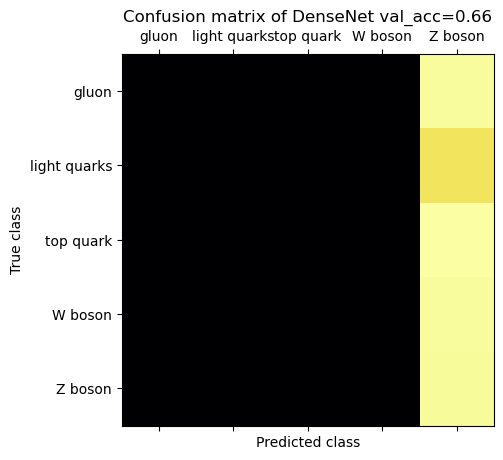

In [50]:
#class instantiation
m = ModelEval(DenseNet, X_val, Y_valid_onehot, model_str="DenseNet val_acc=0.66")

#methods calling
m.confusion_matrix()

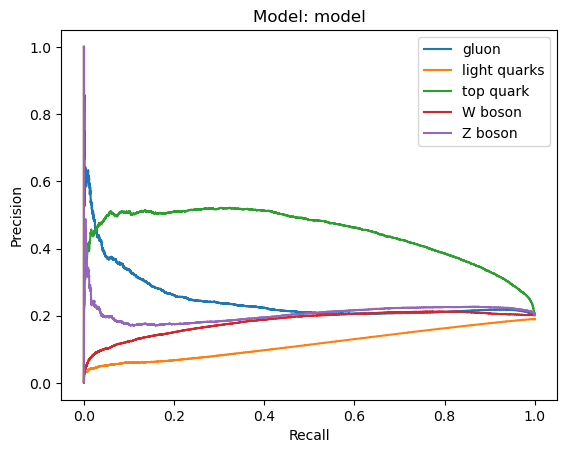

In [37]:
m.PR_study_multiclass()